# Download Data

In [ ]:
tr_path = "covid.train.csv"
tt_path = "covid.test.csv"

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 31.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 10.3MB/s]


# Import Some Package

In [ ]:
#Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#Data Preprocessing
import numpy as np
import csv
import os

#For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(myseed)

# Some Utilities

In [ ]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# Preprocess

**Dataset**

In [ ]:
class COVID19Dataset(Dataset):
  #Dataset for loading and preprocessing the COVID19 dataset
  def __init__(self, path, mode = 'train', target_only = False):
    self.mode = mode

    #Read data into numpy arrays
    with open(path, 'r') as fp:
      data = list(csv.reader(fp))
      data = np.array(data[1:])[:, 1:].astype(float)
    
    if not target_only:
      feats = list(range(93))
    else:
      feats = list(range(52))
      feats.append(57)
      feats = feats + list(range(58,70))
      feats.append(75)
      feats = feats + list(range(76,88))
      
    if mode == 'test':
      data = data[:, feats]
      self.data = torch.FloatTensor(data)
    else:
      target = data[:, -1]
      data = data[:, feats]

      if mode == 'train':
        indices = [i for i in range(len(data)) if i % 10 != 0]
      elif mode == 'dev':
        indices = [i for i in range(len(data)) if i % 10 == 0]
      
      self.data = torch.FloatTensor(data[indices])
      self.target = torch.FloatTensor(target[indices])

    #Normalize features (you may remove this part to see what will happen)
    #Normal distribution
    self.data[:, 40:] = \
      (self.data[:, 40:] - self.data[:, 40:].mean(dim = 0, keepdim = True))\
      / self.data[:, 40:].std(dim = 0, keepdim = True) 

    self.dim = self.data.shape[1]
    print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'.format(mode, len(self.data), self.dim))
  def __getitem__(self, index):
    #Returns one sample at a time
    if self.mode in ['train', 'dev']:
      return self.data[index], self.target[index]
    else:
      return self.data[index]
  def __len__(self):
    return len(self.data)



**DataLoader**

In [ ]:
def prep_dataloader(path, mode, batch_size, n_jobs = 0, target_only = False):
  #Generates a dataset, then is put into a dataloader
  dataset = COVID19Dataset(path, mode = mode, target_only = target_only)
  dataloader = DataLoader(
      dataset,batch_size,shuffle = (mode == 'train'), drop_last = False,
      num_workers = n_jobs, pin_memory = True
  )
  return dataloader

**Deep Neural Network**

In [ ]:
class NeuralNet(nn.Module):
  #a simple fully-connected deep neural network
  def __init__(self, input_dim):
    super(NeuralNet, self).__init__()

    self.net = nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )

    self.criterion = nn.MSELoss(reduction = 'mean')
  def forward(self, x):
    return self.net(x).squeeze(1)
  def cal_loss(self, pred, target):
    L1_norm = 0.001 * sum(p.abs().sum() for p in self.net.parameters())
    L2_norm = 0.0001 * sum((p * p).sum() for p in self.net.parameters())
    return self.criterion(pred, target) + L1_norm + L2_norm

# Train/Dev/Test

**Training**

In [ ]:
def train(tr_set, dv_set, model, config, device):
  #DNN training
  n_epochs = config['n_epochs']

  optimizer = getattr(torch.optim, config['optimizer'])(
      model.parameters(), **config['optim_hparas'])
  min_mse = 1000
  loss_record = {'train': [], 'dev': []}
  early_stop_cnt = 0
  epoch = 0
  while epoch < n_epochs:
    model.train()
    for x, y in tr_set:
      optimizer.zero_grad()
      x, y = x.to(device),y.to(device)
      pred = model(x)
      mse_loss = model.cal_loss(pred, y)
      mse_loss.backward()
      optimizer.step()
      loss_record['train'].append(mse_loss.detach().cpu().item())
    dev_mse = dev(dv_set, model, device)
    if dev_mse < min_mse:
      min_mse = dev_mse
      print('Saving model (epochs = {:4d}, loss = {:.4f})'.format(epoch + 1,min_mse))
      torch.save(model.state_dict(), config['save_path'])
      early_stop_cnt = 0
    else:
      early_stop_cnt += 1
    epoch += 1
    loss_record['dev'].append(dev_mse)
    if early_stop_cnt > config['early_stop']:
      break
  print('Finish training after {} epochs'.format(epoch))
  return min_mse, loss_record


**Validation**

In [ ]:
def dev(dv_set, model, device):
  model.eval()
  total_loss = 0
  for x, y in dv_set:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
      pred = model(x)
      mse_loss = model.cal_loss(pred, y)
    total_loss += mse_loss.detach().cpu().item() * len(x)
  total_loss = total_loss / len(dv_set.dataset)
  return total_loss

**Testing**

In [ ]:
def test(tt_set, model, device):
  model.eval()
  preds = []
  for x in tt_set:
    x = x.to(device)
    with torch.no_grad():
      pred = model(x)
      preds.append(pred.detach().cpu())
  preds = torch.cat(preds, dim = 0).numpy()
  return preds

**Setup Hyper-parameters**

In [ ]:
device = get_device()
os.makedirs('models', exist_ok = True)
target_only = True

config = {
    'n_epochs': 3000,
    'batch_size': 270,
    'optimizer': 'Adam',
    'optim_hparas': {
        'lr': 0.03,
        #'momentum': 0.3
    },
    'early_stop': 500,
    'save_path': 'models/model.pth'
}

**Load data and model**

In [ ]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 78)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 78)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 78)


In [ ]:
model = NeuralNet(tr_set.dataset.dim).to(device)

**Start Training**

In [ ]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epochs =    1, loss = 77.3179)
Saving model (epochs =    2, loss = 34.5199)
Saving model (epochs =    3, loss = 20.5459)
Saving model (epochs =    4, loss = 11.1690)
Saving model (epochs =    5, loss = 6.8571)
Saving model (epochs =    6, loss = 4.8166)
Saving model (epochs =    7, loss = 3.8294)
Saving model (epochs =    8, loss = 3.2410)
Saving model (epochs =    9, loss = 3.0267)
Saving model (epochs =   10, loss = 2.8062)
Saving model (epochs =   11, loss = 2.5931)
Saving model (epochs =   12, loss = 2.4830)
Saving model (epochs =   14, loss = 2.3158)
Saving model (epochs =   16, loss = 2.1250)
Saving model (epochs =   18, loss = 2.0822)
Saving model (epochs =   20, loss = 2.0000)
Saving model (epochs =   21, loss = 1.9354)
Saving model (epochs =   22, loss = 1.9233)
Saving model (epochs =   26, loss = 1.8167)
Saving model (epochs =   29, loss = 1.7192)
Saving model (epochs =   32, loss = 1.6565)
Saving model (epochs =   34, loss = 1.6333)
Saving model (epochs =   37,

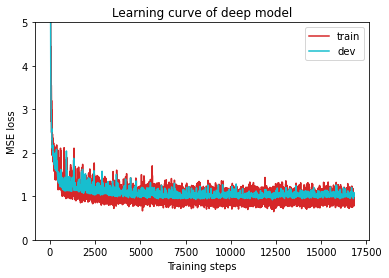

In [ ]:
plot_learning_curve(model_loss_record, title = 'deep model')

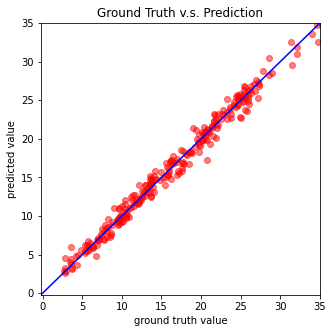

In [ ]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location = 'cpu')
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)

**Testing**

In [ ]:
def save_pred(preds, file):
  #Save predictions to specified file
  print('Saving results to {}'.format(file))
  with open(file, 'w') as fp:
    writer = csv.writer(fp)
    writer.writerow(['id', 'tested_positive'])
    for i, p in enumerate(preds):
      writer.writerow([i, p])
preds = test(tt_set, model, device)
save_pred(preds, 'pred.csv')

Saving results to pred.csv
